# Amazon Fine Food Reviews Analysis

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).



#### Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 
import nltk
import string

import scipy
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import warnings
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from prettytable import PrettyTable

warnings.filterwarnings("ignore")


### 1 Loading the data

In [50]:

#connecting to database
con = sqlite3.connect('database.sqlite')
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
filtered_data['Score'] = actualScore.map(partition)

filtered_data.shape
#filtered_data.head()

(525814, 10)

### 2 Data Cleaning

In [51]:
#sorting the data according to productId
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

#Removing entries where helfulnessNumerator>HelpfulnessDenominator
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

final.shape
final['Score'].value_counts()



positive    307061
negative     57110
Name: Score, dtype: int64

### 3 Text Preprocessing

In [52]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1
    
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
final.shape

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\javadlam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(364171, 11)

In [53]:
final.head()
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [3]:

con = sqlite3.connect("final.sqlite")
cleaned_data = pd.read_sql_query("select * from Reviews", con)
cleaned_data.shape
#cleaned_data.head()

(364171, 12)

In [4]:
#Sampling 20k points

final_data = cleaned_data.sample(n=50000)
#final_data.head()
print(final_data.shape)
final_data['Score'].value_counts()


(50000, 12)


positive    42291
negative     7709
Name: Score, dtype: int64

In [5]:
# sorting the data based on time

final_data['Time'] = pd.to_datetime(final_data['Time']).sort_values()
#final_data.head()

##### Function to find Optimal K using GridSearch CV and bruteforce algorithm

In [6]:
def find_optimalK_brute(X_train,Y_train):
   
    tuned_parameters = {'n_neighbors':np.arange(1,50,2)} 
    tscv = TimeSeriesSplit(n_splits=3)
    clf = KNeighborsClassifier(algorithm = "brute")
    model = GridSearchCV(clf, tuned_parameters, cv=tscv)
    model.fit(X_train, Y_train)
    model_mean_scores = [result.mean_validation_score for result in model.grid_scores_]
    #print(grid_mean_scores)

    plt.plot(np.arange(1,50,2), model_mean_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.title('Accuracy Vs K')
    print(model.best_score_)
    print(model.best_params_)
    print(model.best_estimator_)

##### Function to find Optimal K using GridSearch CV and Kdtree algorithm

In [7]:
def find_optimalK_kdtree(X_train,Y_train):
   
    tuned_parameters = {'n_neighbors':np.arange(1,50,2)} 
    tscv = TimeSeriesSplit(n_splits=5)
    clf = KNeighborsClassifier(algorithm = "kd_tree")
    model = GridSearchCV(clf, tuned_parameters, cv=tscv)
    model.fit(X_train, Y_train)
    model_mean_scores = [result.mean_validation_score for result in model.grid_scores_]
    #print(grid_mean_scores)

    plt.plot(np.arange(1,50,2), model_mean_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.title('Accuracy Vs K')
    print(model.best_score_)
    print(model.best_params_)
    print(model.best_estimator_)
    

### 4 BOW

In [8]:
#Splitting the data into train and test
X = final_data['CleanedText']
Y = final_data['Score']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
print(X_train.shape,X_test.shape)
#print(X_train)
type(X_train)

(35000,) (15000,)


pandas.core.series.Series

In [9]:
#Converting the text to vector using BOW
unigram_bow = CountVectorizer()
X_train = unigram_bow.fit_transform(X_train)

# Standardizing data
scaler = preprocessing.StandardScaler(with_mean=False).fit(X_train)
X_train = scaler.transform(X_train)  

X_test = unigram_bow.transform(X_test)
X_test = scaler.transform(X_test) 

print(X_train.shape,X_test.shape)


(35000, 23299) (15000, 23299)


##### Brute force algorithm

0.8438857142857142
{'n_neighbors': 5}
KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')


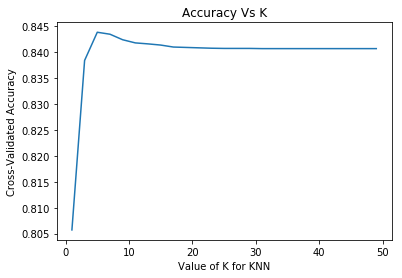

In [279]:
#Finding optimal k using bruteforce algorithm
find_optimalK_brute(X_train, Y_train)

In [10]:
# learning the model with optimal k

knn_optimal = KNeighborsClassifier(n_neighbors=5)

# fitting the model
knn_optimal.fit(X_train, Y_train)

# predict the response
pred_bow = knn_optimal.predict(X_test)

train_acc_bow = knn_optimal.score(X_train, Y_train)
print("Train accuracy", train_acc_bow * 100)
test_acc_bow = accuracy_score(Y_test, pred_bow) * 100
print("Test accuracy", test_acc_bow)

MemoryError: 

             precision    recall  f1-score   support

   negative       0.72      0.04      0.07       934
   positive       0.85      1.00      0.92      5066

avg / total       0.83      0.85      0.79      6000



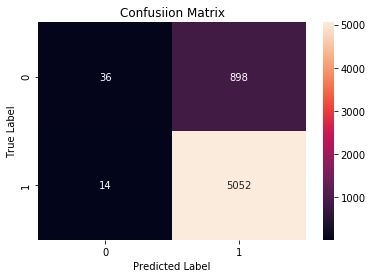

In [259]:
# classification reportSGaSFHJV 
print(classification_report(Y_test, pred_bow))

# plotting confusion matrix
cm_array = confusion_matrix(Y_test,pred_bow)
df_cm = pd.DataFrame(cm_array)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")MN BC
plt.show()

In [176]:
#Reducing the dimensions using TruncatedSVD to perform KNN with kdtree
from sklearn.decomposition import TruncatedSVD

red_dim = TruncatedSVD(n_components=100, random_state=42)
X_train_red = red_dim.fit_transform(X_train)

X_test_red = red_dim.fit_transform(X_test)

print(X_train_red.shape,X_test_red.shape)

(14000, 100) (6000, 100)


##### Kd-tree algorithm

0.8516930990141449
{'n_neighbors': 37}
KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=37, p=2,
           weights='uniform')


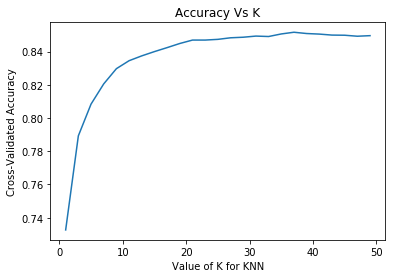

In [177]:
# Finding optimal K

optimal_k_bow_kdtree = find_optimalK_kdtree(X_train_red, Y_train)

In [178]:
# learning the model with optimal k

clf = KNeighborsClassifier(n_neighbors=37)

# fitting the model
clf.fit(X_train_red, Y_train) 


# predict the response
pred = clf.predict(X_test_red)

train_acc_bow = clf.score(X_train_red, Y_train)
print("Train accuracy", train_acc_bow * 100)
test_acc_bow = accuracy_score(Y_test, pred) * 100
print("Test accuracy", test_acc_bow)

Train accuracy 85.70714285714286
Test accuracy 82.66666666666667


             precision    recall  f1-score   support

   negative       0.09      0.01      0.02       934
   positive       0.84      0.98      0.90      5066

avg / total       0.73      0.83      0.77      6000



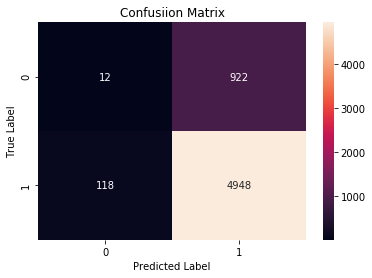

In [179]:
# classification report
print(classification_report(Y_test, pred))

# plotting confusion matrix

cm_array = confusion_matrix(Y_test,pred)
df_cm = pd.DataFrame(cm_array)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observations

* Test Accuracy on unseen test data is 85%, 82% with optimal K = 9, K = 37 for brute force and kdtree algorithms respectively.
* Although Accuracy is good Precision, recall and f1 score are the best metrics when we have an imbalanced dataset which are       good in our case.
* So from the confusion matrix we can see that out of total negative points (934) the model predicted 204 and out of total         positive points (5066) the model predicted 5796 in case of brute force. 
* False positive rate (FPR) is 0.85 that means 85% negative labels are incorrectly classified as positive.
* Brute force and Kdtree gives relatively similar results.
* BOW doesn't perform well because almost 85% of data is misclassified.
                    

### 5 TF-IDF 

In [215]:
X = final_data['CleanedText']
Y = final_data['Score']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

print(X_train.shape,X_test.shape)

(14000,) (6000,)


In [216]:
tfidf = TfidfVectorizer(ngram_range = (1,2))
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)

print(X_train.shape, X_test.shape)


(14000, 303845) (6000, 303845)


##### Brute force algorithm

0.8559794256322332
{'n_neighbors': 9}
KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')


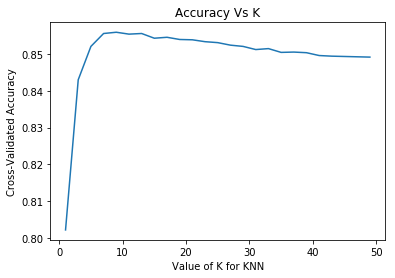

In [182]:
optimal_k_tfidf = find_optimalK_brute(X_train, Y_train)

In [183]:
clf = KNeighborsClassifier(n_neighbors=9)

# fitting the model
clf.fit(X_train, Y_train)

# predict the response
pred = clf.predict(X_test)

train_acc_tfidf = clf.score(X_train, Y_train)
print("Train accuracy", train_acc_tfidf * 100)
test_acc_tfidf = accuracy_score(Y_test, pred) * 100
print("Test accuracy", test_acc_tfidf)

Train accuracy 87.42857142857143
Test accuracy 86.06666666666666


             precision    recall  f1-score   support

   negative       0.79      0.14      0.24       934
   positive       0.86      0.99      0.92      5066

avg / total       0.85      0.86      0.82      6000



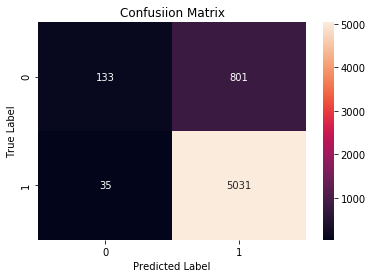

In [184]:
# classification report
print(classification_report(Y_test, pred))

# plotting confusion matrix

cm_array = confusion_matrix(Y_test,pred)
df_cm = pd.DataFrame(cm_array)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [185]:
red_dim = TruncatedSVD(n_components=100, random_state=42)
X_train_red = red_dim.fit_transform(X_train)

X_test_red = red_dim.fit_transform(X_test)

print(X_train_red.shape,X_test_red.shape)

(14000, 100) (6000, 100)


##### Kd-tree algorithm

0.8555507929704244
{'n_neighbors': 25}
KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=25, p=2,
           weights='uniform')


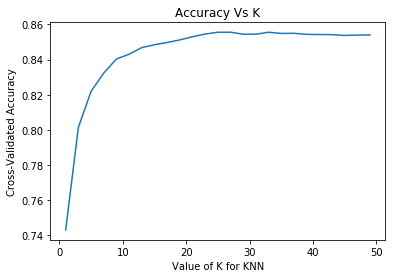

In [186]:
# Finding optimal K

optimal_k_tfidf_kdtree = find_optimalK_kdtree(X_train_red, Y_train)

In [187]:
# learning the model with optimal k

clf = KNeighborsClassifier(n_neighbors=25)

# fitting the model
clf.fit(X_train_red, Y_train)

# predict the response
pred = clf.predict(X_test_red)

train_acc_tfidf = clf.score(X_train_red, Y_train)
print("Train accuracy", train_acc_tfidf * 100)
test_acc_tfidf = accuracy_score(Y_test, pred) * 100
print("Test accuracy", test_acc_tfidf)

Train accuracy 86.57857142857142
Test accuracy 83.13333333333334


             precision    recall  f1-score   support

   negative       0.15      0.02      0.03       934
   positive       0.84      0.98      0.91      5066

avg / total       0.74      0.83      0.77      6000



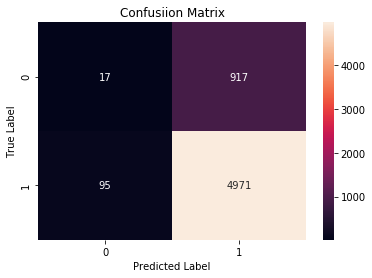

In [188]:
# classification report
print(classification_report(Y_test, pred))

# plotting confusion matrix
cm_array = confusion_matrix(Y_test,pred)
df_cm = pd.DataFrame(cm_array)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observations

* Test Accuracy on unseen test data is 86%, 83% with optimal K = 9, K = 25 for brute force and kdtree algorithms respectively.
* Although Accuracy is good Precision, recall and f1 score are the best metrics when we have an imbalanced dataset which are       good in our case.
* So from the confusion matrix we can see that out of total negative points (934) the model predicted 112 and out of total         positive points (5066) the model predicted 5888 in case of kdtree. 
* False positive rate (FPR) is 0.98 that means 98% negative labels are incorrectly classified as positive.
* Brute force and Kdtree gives relatively similar results.
* TF-IDF is a dumb model because almost the data is classified as positive class.
                    

### 6 Word2Vec

In [218]:
X = final_data['CleanedText']
Y = final_data['Score']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
print(X_train.shape,X_test.shape)
#print(X_train)

(14000,) (6000,)


In [219]:
from gensim.models import Word2Vec
i=0

list_of_sent=[]
for sent in X_train:
    list_of_sent.append(sent.split())
    
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
w2v_words = np.array(w2v_words)
w2v_words.shape


(5229,)

In [220]:
from gensim.models import Word2Vec
i=0

list_of_sent_test=[]
for sent in X_test:
    list_of_sent_test.append(sent.split())
w2v_model=Word2Vec(list_of_sent_test,min_count=5,size=50, workers=4)
w2v_model.wv.most_similar('tast')
w2v_words = list(w2v_model.wv.vocab)
w2v_words = np.array(w2v_words)
w2v_words.shape


(3585,)

### 7 Avg Word2Vec

In [192]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors = np.array(sent_vectors)
print(sent_vectors.shape)

(14000, 50)


In [193]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)

(6000, 50)


##### Brute force algorithm

0.8454350621517359
{'n_neighbors': 49}
KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=49, p=2,
           weights='uniform')


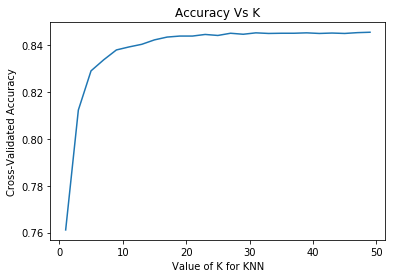

In [194]:
X_train = sent_vectors
X_test = sent_vectors_test
X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)
optimal_k_avgw2v = find_optimalK_brute(X_train, Y_train)

In [195]:
clf = KNeighborsClassifier(n_neighbors=49)

# fitting the model
clf.fit(X_train, Y_train)

# predict the response
pred = clf.predict(X_test)

train_acc_avgw2v = clf.score(X_train, Y_train)*100
print("Train accuracy", train_acc_avgw2v)
test_acc_avgw2v = accuracy_score(Y_test, pred) * 100
print("Test accuracy", test_acc_avgw2v)

Train accuracy 84.56428571428572
Test accuracy 84.39999999999999


             precision    recall  f1-score   support

   negative       0.43      0.01      0.01       934
   positive       0.84      1.00      0.92      5066

avg / total       0.78      0.84      0.77      6000



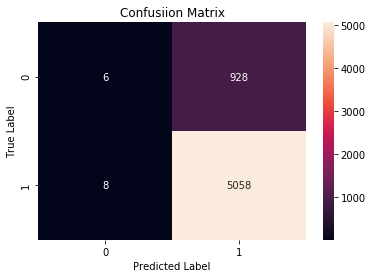

In [196]:
# classification report
print(classification_report(Y_test, pred))

# plotting confusion matrix
cm_array = confusion_matrix(Y_test,pred)
df_cm = pd.DataFrame(cm_array)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [197]:
red_dim = TruncatedSVD(n_components=30, random_state=42)
X_train_red = red_dim.fit_transform(X_train)

X_test_red = red_dim.fit_transform(X_test)

print(X_train_red.shape,X_test_red.shape)

(14000, 30) (6000, 30)


##### Kd-tree algorithm

0.8453493356193742
{'n_neighbors': 49}
KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=49, p=2,
           weights='uniform')


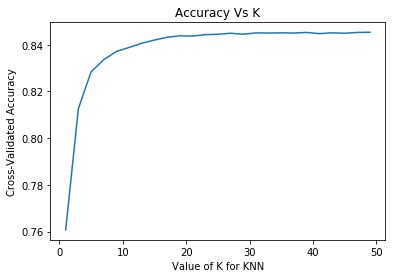

In [198]:
optimal_k_avgw2v = find_optimalK_kdtree(X_train_red, Y_train)

In [199]:
# learning the model with optimal k

clf = KNeighborsClassifier(n_neighbors=49)

# fitting the model
clf.fit(X_train_red, Y_train)

# predict the response
pred = clf.predict(X_test_red)

train_acc_avgw2v = clf.score(X_train_red, Y_train)*100
print("Train accuracy", train_acc_avgw2v)
test_acc_avgw2v = accuracy_score(Y_test, pred) * 100
print("Train accuracy", test_acc_avgw2v)

Train accuracy 84.57142857142857
Train accuracy 84.41666666666666


             precision    recall  f1-score   support

   negative       0.45      0.01      0.01       934
   positive       0.84      1.00      0.92      5066

avg / total       0.78      0.84      0.77      6000



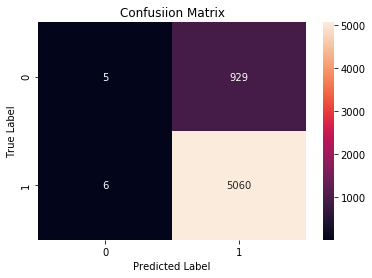

In [200]:
# classification report
print(classification_report(Y_test, pred))

# plotting confusion matrix
cm_array = confusion_matrix(Y_test,pred)
df_cm = pd.DataFrame(cm_array)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 8 TF-IDF weighted Word2Vec

In [202]:

tfidf_feat = tfidf.get_feature_names() # tfidf words/col-names
 
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_train[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
tfidf_sent_vectors = np.array(tfidf_sent_vectors)
print(tfidf_sent_vectors.shape)

(14000, 50)


In [222]:

tfidf_feat = tfidf.get_feature_names() 
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_test[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)
print(tfidf_sent_vectors_test.shape)

(6000, 50)


##### Brute force algorithm

0.8453493356193742
{'n_neighbors': 41}
KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=41, p=2,
           weights='uniform')


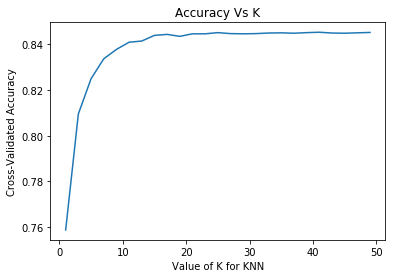

In [223]:
X_train = tfidf_sent_vectors
X_test = tfidf_sent_vectors_test
X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)
optimal_k_tfidfw2v = find_optimalK_brute(X_train, Y_train)

In [224]:
clf = KNeighborsClassifier(n_neighbors=41)

# fitting the model
clf.fit(X_train, Y_train)

# predict the response
pred = clf.predict(X_test)

train_acc_tfidfw2v = clf.score(X_train, Y_train)*100
print("Train accuracy", train_acc_tfidfw2v)
test_acc_tfidfw2v = accuracy_score(Y_test, pred) * 100
print("Test accuracy", test_acc_tfidfw2v)

Train accuracy 84.60714285714286
Test accuracy 84.39999999999999


             precision    recall  f1-score   support

   negative       0.33      0.00      0.00       934
   positive       0.84      1.00      0.92      5066

avg / total       0.76      0.84      0.77      6000



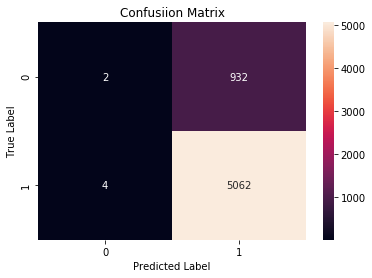

In [225]:
# classification report
print(classification_report(Y_test, pred))

# plotting confusion matrix
cm_array = confusion_matrix(Y_test,pred)
df_cm = pd.DataFrame(cm_array)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [226]:
X_train = tfidf_sent_vectors
X_test = tfidf_sent_vectors_test
red_dim = TruncatedSVD(n_components=20, random_state=42)
X_train_red = red_dim.fit_transform(X_train)

X_test_red = red_dim.fit_transform(X_test)

print(X_train_red.shape,X_test_red.shape)

(14000, 20) (6000, 20)


##### Kd-tree algorithm

0.8455207886840977
{'n_neighbors': 45}
KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=45, p=2,
           weights='uniform')


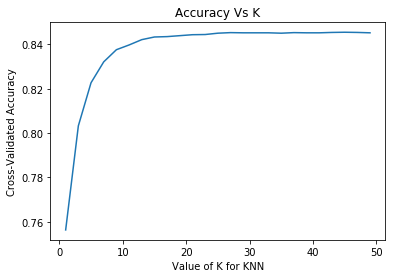

In [228]:
optimal_k_tfidfw2v_kdtree = find_optimalK_kdtree(X_train_red, Y_train)

In [229]:
# learning the model with optimal k

clf = KNeighborsClassifier(n_neighbors=45)

# fitting the model
clf.fit(X_train_red, Y_train)

# predict the response
pred = clf.predict(X_test_red)

train_acc_tfidfw2v = clf.score(X_train_red, Y_train)*100
print("Train accuracy", train_acc_tfidfw2v)
test_acc_tfidfw2v = accuracy_score(Y_test, pred) * 100

print("Train accuracy", test_acc_tfidfw2v)

Train accuracy 84.50714285714285
Train accuracy 84.43333333333334


             precision    recall  f1-score   support

   negative       0.00      0.00      0.00       934
   positive       0.84      1.00      0.92      5066

avg / total       0.71      0.84      0.77      6000



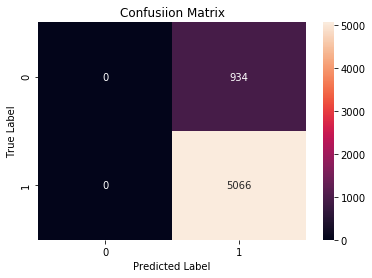

In [230]:
# classification report
print(classification_report(Y_test, pred))

# plotting confusion matrix
cm_array = confusion_matrix(Y_test,pred)
df_cm = pd.DataFrame(cm_array)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observations

* Word2Vec and TF-IDF didn't perform well because almost all the data is classified as positive class.

In [231]:
x = PrettyTable()

x.field_names = ["Model","Algorithm", "HyperParameter(K)", "Accuracy"]

x.add_row(["BOW", "Brute",9,85.33])
x.add_row(["BOW", "Kd-tree", 37,82.6])
x.add_row(["TF-IDF","Brute", 9,86.06])
x.add_row(["TF-IDF","Kd-tree", 25,83.13])
x.add_row(["Average W2V","Brute", 49,84.39])
x.add_row(["Average W2V","Kd-tree", 49,84.416])
x.add_row(["TF-IDF W2V","Brute", 41,84.39])
x.add_row(["TF-IDF W2V","kd-tree", 45,84.43])

print(x)

+-------------+-----------+-------------------+----------+
|    Model    | Algorithm | HyperParameter(K) | Accuracy |
+-------------+-----------+-------------------+----------+
|     BOW     |   Brute   |         9         |  85.33   |
|     BOW     |  Kd-tree  |         37        |   82.6   |
|    TF-IDF   |   Brute   |         9         |  86.06   |
|    TF-IDF   |  Kd-tree  |         25        |  83.13   |
| Average W2V |   Brute   |         49        |  84.39   |
| Average W2V |  Kd-tree  |         49        |  84.416  |
|  TF-IDF W2V |   Brute   |         41        |  84.39   |
|  TF-IDF W2V |  kd-tree  |         45        |  84.43   |
+-------------+-----------+-------------------+----------+


### 9 Conclusions

* As I have taken only 20k points due to hardware limitations all the metrics reported may not represent real metrics.
* On whole BOW performed slightly better when compared to all vectorization techniques.
* KNN doesn't work good for this dataset and it is also a slow algorithm.
